### Загрузите данные и подготовьте их к анализу

# Анализ рекламных кампаний приложения Procrastinate Pro+

**Цель исследования** — проанализировать доходы, расходы и окупаемость рекламы приложения и дать рекомендацию маркетологам.    

**Ход исследования**:  

Данные о пользователях предоставлены в разных таблицах в необработанном виде. Необходимо создаьть профили пользователей, изучить такие показатели, как LTV, CAC, ROI для разных когорт, выявить проблемные места.  

Таким образом, исследование пройдёт в четыре **этапа**:  

1. Обзор данных;  
2. Предобработка данных;  
3. Анализ данных;  
4. Вывод и рекомендации по произведённому анализу.


Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

Импортируем необходимые для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


Выгружаем основную информацию по каждому датафрейму:

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('/puppies/visits_info_short.csv') 

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('/puppies/orders_info_short.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [4]:
try:
    costs =  pd.read_csv('/datasets/costs_info_short.csv')
except:
    costs = pd.read_csv('/puppies/costs_info_short.csv')

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Для удобства в дальнейшей работе переименовываем столбцы в датафреймах:

In [5]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

In [6]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

In [7]:
costs = costs.rename(columns= {'Channel':'channel'})

Проверим пустые значения и дубликаты

In [8]:
print (visits.isna().sum())
print ('Количество дубликатов: ',visits.duplicated().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
Количество дубликатов:  0


In [9]:
print (orders.isna().sum())
print ('Количество дубликатов: ',orders.duplicated().sum())

user_id     0
event_dt    0
revenue     0
dtype: int64
Количество дубликатов:  0


In [10]:
print (costs.isna().sum())
print ('Количество дубликатов: ',costs.duplicated().sum())

dt         0
channel    0
costs      0
dtype: int64
Количество дубликатов:  0


Преобразовываем столбцы с датой и временем в корректные типы:

In [11]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime (visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date


Данные в датафреймах предоставлены качественно, нет пустых значений, дубликатов и типы данных корректны во всех столбцах, кроме столбцов с датой. 

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**Для дальнейших анализа и визуализации введём несколько функций:**

#### Функция для создания пользовательских профилей

In [12]:
def get_profiles(visits, orders, ad_costs, event_names=[]):
    
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для расчёта удержания

In [13]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

#### Функция для расчёта конверсии

In [14]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

#### Функция для расчёта LTV и ROI

In [15]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped, 
        result_in_time, 
        roi_grouped,  
        roi_in_time,  
    )

#### Функция для сглаживания фрейма

In [16]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для визуализации удержания

In [17]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

   
    retention = retention.drop(columns=['cohort_size', 0])
    
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    
    ax3 = plt.subplot(2, 2, 3)
   
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция для визуализации конверсии

In [18]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    
    plt.figure(figsize=(15, 5))

    
    conversion = conversion.drop(columns=['cohort_size'])
    #
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция для визуализации LTV и ROI

In [19]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    
    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

   
    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)

    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика CAC')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)

    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

Вызовем функцию get_profiles:

In [20]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


Найдём минимальную и максимальную даты привлечения пользователей:

In [21]:
min_date = profiles['dt'].min()
print (min_date)
max_date = profiles['dt'].max()
print (max_date)

2019-05-01
2019-10-27


Пользователи приходили на протяжении всего исследуемого периода. Значит, проблем с передачей данных нет, и снижение доходов не является технической ошибкой.

Проверим, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей:

In [22]:
payers_country = profiles.pivot_table(index='region', values='payer',aggfunc='sum')

In [23]:
id_country = profiles.pivot_table(index='region', values='user_id',aggfunc='count')

In [24]:
profiles_country = (id_country.merge(payers_country, on='region', how='left')
                              .sort_values(by='user_id',ascending=False)
                   )
profiles_country['proportion_of_payers'] = payers_country['payer']/id_country['user_id']*100
display (profiles_country)

,user_id,payer,proportion_of_payers
region,,,
United States,100002,6902,6.901862
UK,17575,700,3.982930
France,17450,663,3.799427
Germany,14981,616,4.111875


Подавляющее большинство пользователей зарегистрированы в США. Также в США самый высокий процент покупателей среди пользователей.
В тройку лидеров также входят Британия и Франция с практически равным количеством пользователей, однако на втором месте по покупкам находится Германия. 

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи:

In [25]:
payers_device = profiles.pivot_table(index='device', values='payer',aggfunc='sum')

In [26]:
id_device = profiles.pivot_table(index='device', values='user_id',aggfunc='count')

In [27]:
profiles_device = (id_device.merge(payers_device, on='device', how='left')
                            .sort_values(by='user_id',ascending=False)
                  )
profiles_device['proportion_of_payers'] = payers_device['payer']/id_device['user_id']*100
display (profiles_device)

,user_id,payer,proportion_of_payers
device,,,
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790
Mac,30042,1912,6.364423


Большинство пользователей используют IPhone, на втором месте Android. На третьем месте по популярности пользователи используют PC, однако покупки с них совершают меньше всего. Лидируют по покупкам пользователи, использующие Mac и IPhone.

Проверим каналы, откуда пришло больше всего платящих пользователей:

In [28]:
payers_channel = profiles.pivot_table(index='channel', values='payer',aggfunc='sum')

In [29]:
id_channel = profiles.pivot_table(index='channel', values='user_id',aggfunc='count')

In [30]:
profiles_channel = (id_channel.merge(payers_channel['payer'], on='channel', how='left')
                              .sort_values(by='user_id',ascending=False)
                   )
profiles_channel['proportion_of_payers'] = payers_channel['payer']/id_channel['user_id']*100
display (profiles_channel)

,user_id,payer,proportion_of_payers
channel,,,
organic,56439,1160,2.055316
FaceBoom,29144,3557,12.204914
TipTop,19561,1878,9.600736
OppleCreativeMedia,8605,233,2.707728
LeapBob,8553,262,3.063253
WahooNetBanner,8553,453,5.296387
RocketSuperAds,4448,352,7.913669
MediaTornado,4364,156,3.574702
YRabbit,4312,165,3.826531


Можно заметить, что больше всего пользователей приходят не через рекламу, однако по покупательской способности органика на последнем месте.
Наибольшее кол-во покупок совершают пользователи, которые пришли из канала FaceBoom. На втором и третьем местах находятся каналы с наименьшим количеством пользователей: AdNonSense и lambdaMediaAds. Стоит обратить внимание на наиболее конвертирующие каналы.

Данные для анализа полные - с 1 мая по 27 октября 2019 года. Подавляющее большинство пользователей зарегистрированы в США и там же самый высокий процент платящих пользователей. У пользователей, пользующихся продукцией Apple, самый высокий процент платящих покупателей, также большинство пользователей пользуются iPhone.  
Большинство пользователей приходят через органику, однако у них самый низкий процент покупок. Далее в анализе мы отбросим пользователей через органику для более корректного анализа показателей именно рекламных.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [31]:
total_costs = costs['costs'].sum().round()
print ('Общая сумма расходов: ',total_costs)

Общая сумма расходов:  105497.0


Распределение затрат по каналам

In [32]:
costs_channel = (costs.pivot_table(index='channel', values='costs',aggfunc='sum')
                      .sort_values (by='costs', ascending=False)
                )
display (costs_channel)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


На TipTop и FaceBoom приходится наибольшее количество затрат, причём с большим отрывом от остальных: затраты на WahooNetBanner в 6 раз меньше, чем у FaceBoom.

Добавляем новые столбцы и строим графики динамики затрат по каналам

In [33]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

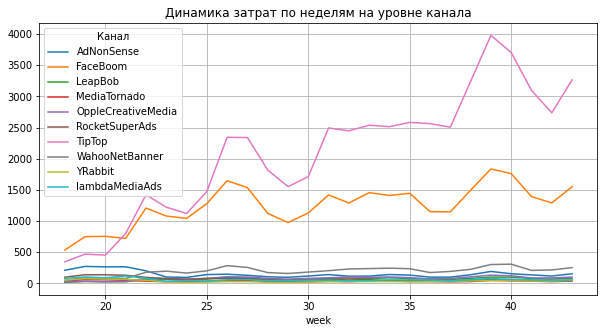

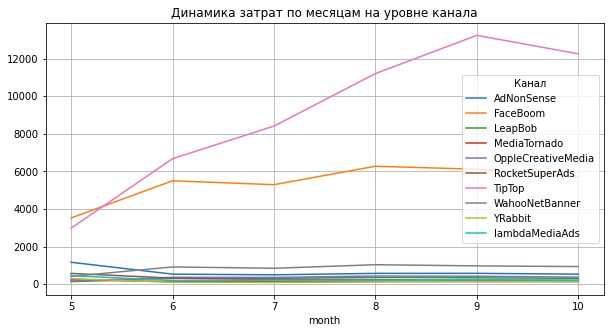

In [34]:
week_costs = (costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
                   .plot(grid=True,figsize=(10,5))
             )
plt.legend(title='Канал')
plt.title('Динамика затрат по неделям на уровне канала')
 
month_costs = (costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
                    .plot(grid=True,figsize=(10,5))
              )
plt.legend(title='Канал')
plt.title('Динамика затрат по месяцам на уровне канала')

plt.show();

Затраты на TipTop значительно превышают остальные, но втором месте идёт FaceBoom. Так как ранее было выявлено, что большинство пользователей пришло именно с этих каналов, на первый взгляд логично, что в них больше всего вкладываются, но стоит также исследовать и другие показатели.

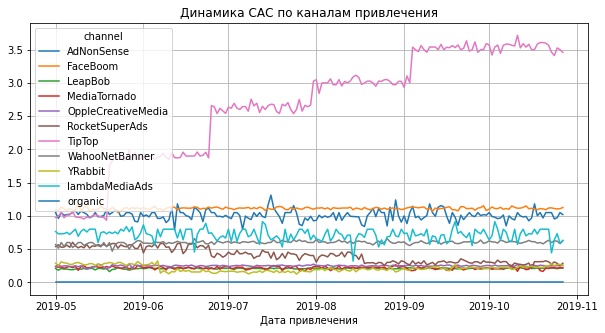

In [35]:
(profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean')
         .plot(grid=True, figsize=(10, 5))
)
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Отличный и наглядный график 👍
    
Здорово, что визуализировала динамику САС по каналам
    
</div>

TipTop лидирует в стоимости привлечения одного клиента, более того, этот показатель только увеличивается. Очевидно, что необходимо перераспределение бюджета и снижения роли TipTop в общем перечне каналов.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.  
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.  
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.  
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.  
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.  
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Введём момент и горизонт когортного анализа

In [36]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

**Конверсия пользователей и её динамика:**

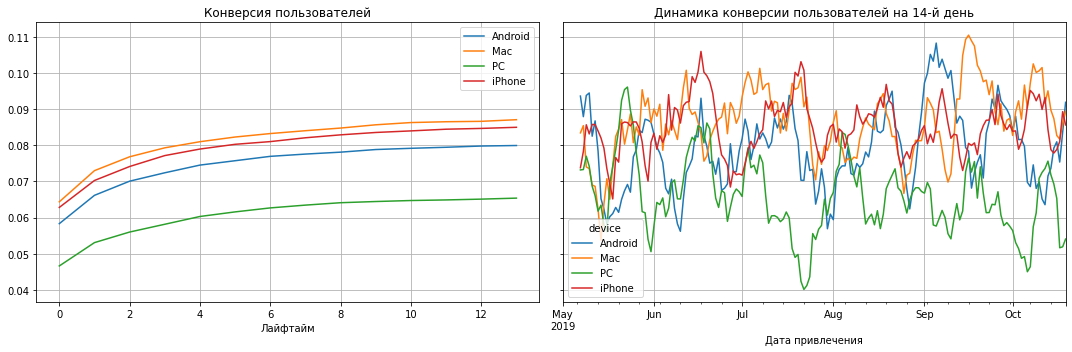

In [37]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
)
plot_conversion(conversion, conversion_history, 14) 

Наиболее высокие показатели демонстрирует платформа Mac, чуть хуже конвертят пользователи, использующие платформы iPhone и Android.  
Хуже всех конверсия наблюдается у пользователей на платформе PC. На графике динамики видно, что показатели конверсии нестабильны, также принимают самые минимальные значения.

**График динамики удержания пользователей:**

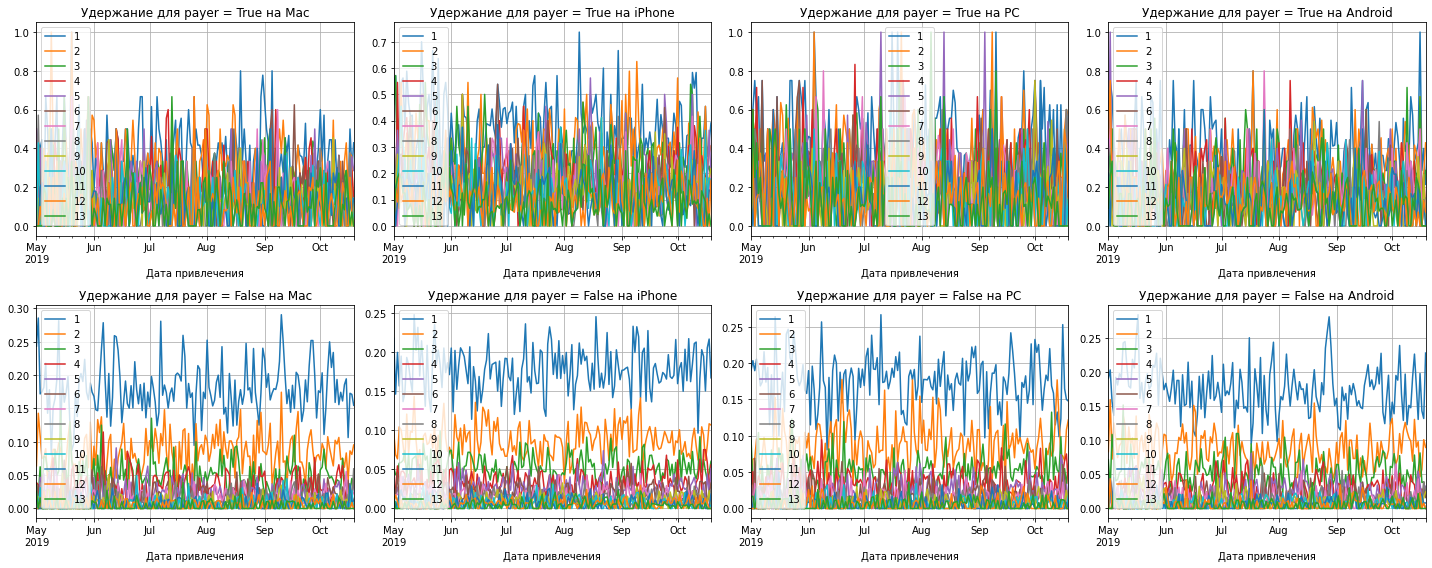

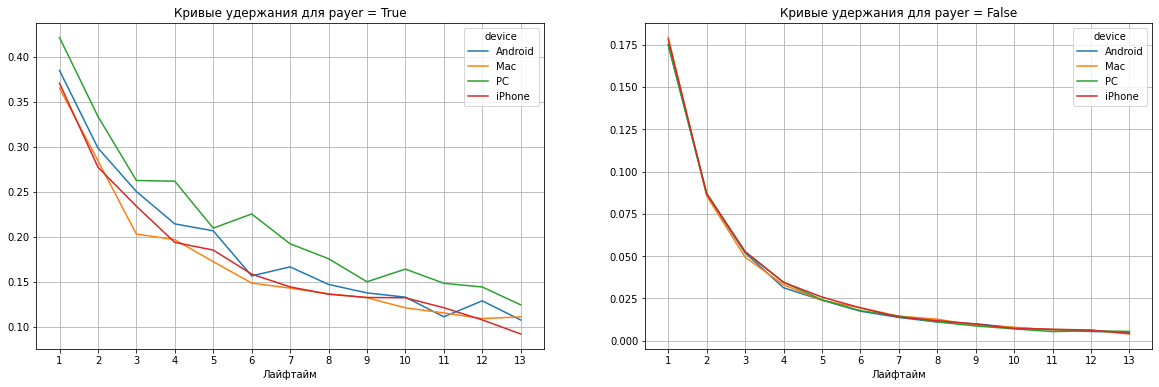

In [38]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plt.figure(figsize=(20, 8))

report = retention_history.drop(columns=['cohort_size', 0])

num_rows = len(profiles['payer'].unique())
num_cols = len(profiles['device'].unique())

for i, payer in enumerate(profiles['payer'].unique()):
    for j, device in enumerate(profiles['device'].unique()):
        (
            report.query('payer == @payer and device == @device')
            .droplevel(['payer', 'device'])
            .plot(
                grid=True,
                ax=plt.subplot(num_rows, num_cols, i * num_cols + j + 1),
            )
        )
        plt.xlabel('Дата привлечения')
        plt.title('Удержание для payer = {} на {}'.format(payer, device))
plt.tight_layout()


plt.figure(figsize=(20, 6))

report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

На графике удержания платящих пользователей очевидно лидируют пользователи PC. На протяжении всех лайфтаймов этот вид устройства лидирует, однако на шестой день показатель практически равняется с пользователями Android.  
График удержания неплатящих пользователей примерно равен для всех платформ.

**Графики окупаемости рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI:**

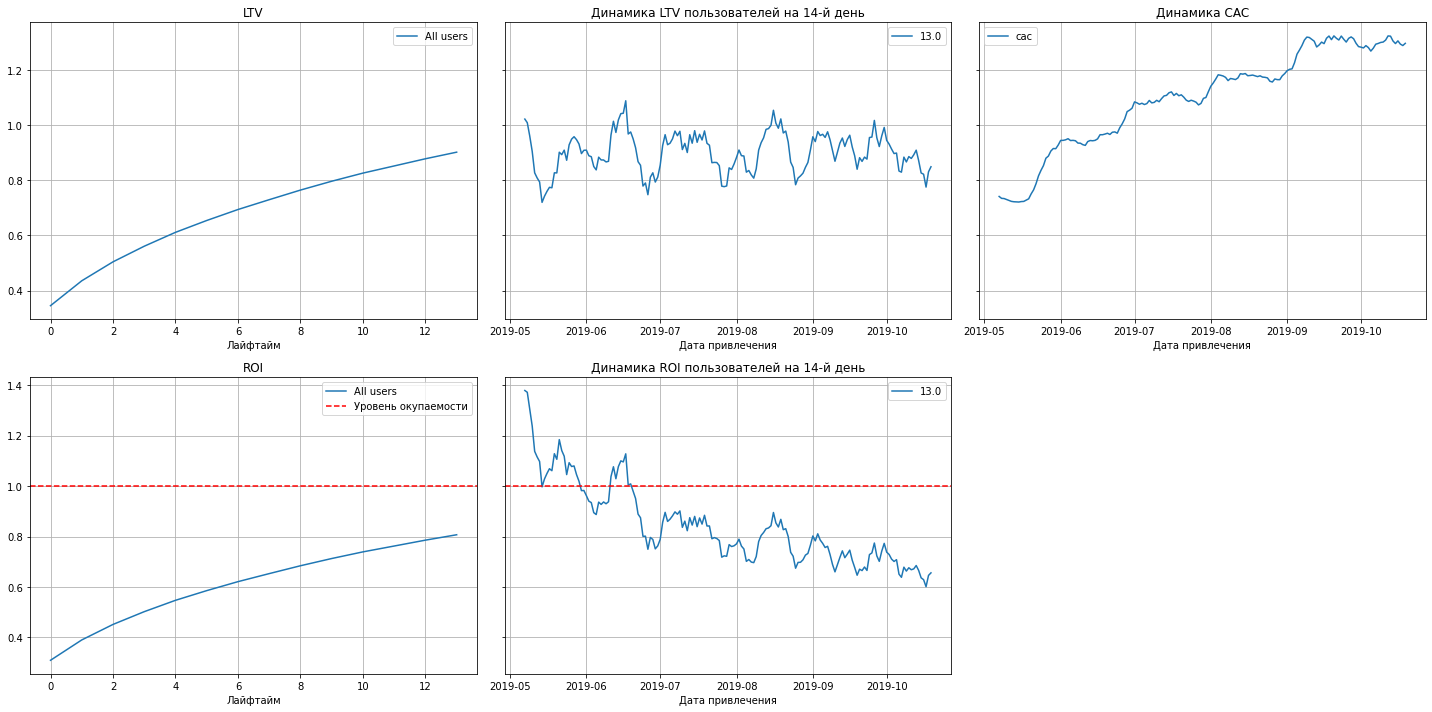

In [39]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

 1. Кривая LTV растёт, что в порядке нормы;  
 2. Расходы на рекламу также возрастают, однако согласно ROI только под конец исследуемого периода реклама почти окупается. Согласно динамике ROI, она стремительно падает.

Общий график конверсии:

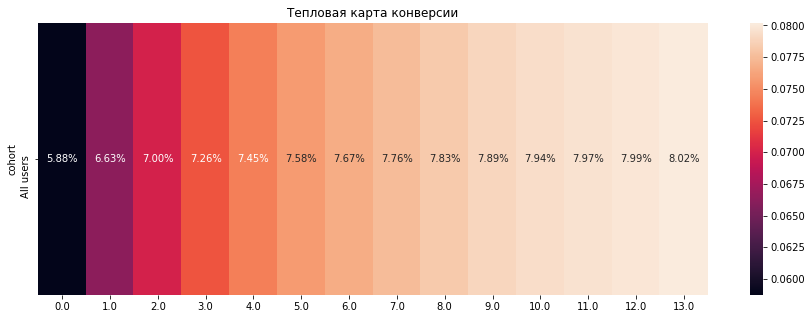

In [40]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии')
plt.show();

Глядя на общий хитмеп конверсии, видно, что Converstion Rate перманентно увеличивается на протяжении всего исследуемого периода. Количество покупателей в приложении Procrastinate Pro+ увеличивается с каждым днём, с 5,88% до 8,02%.

Общий график удержания пользователей:

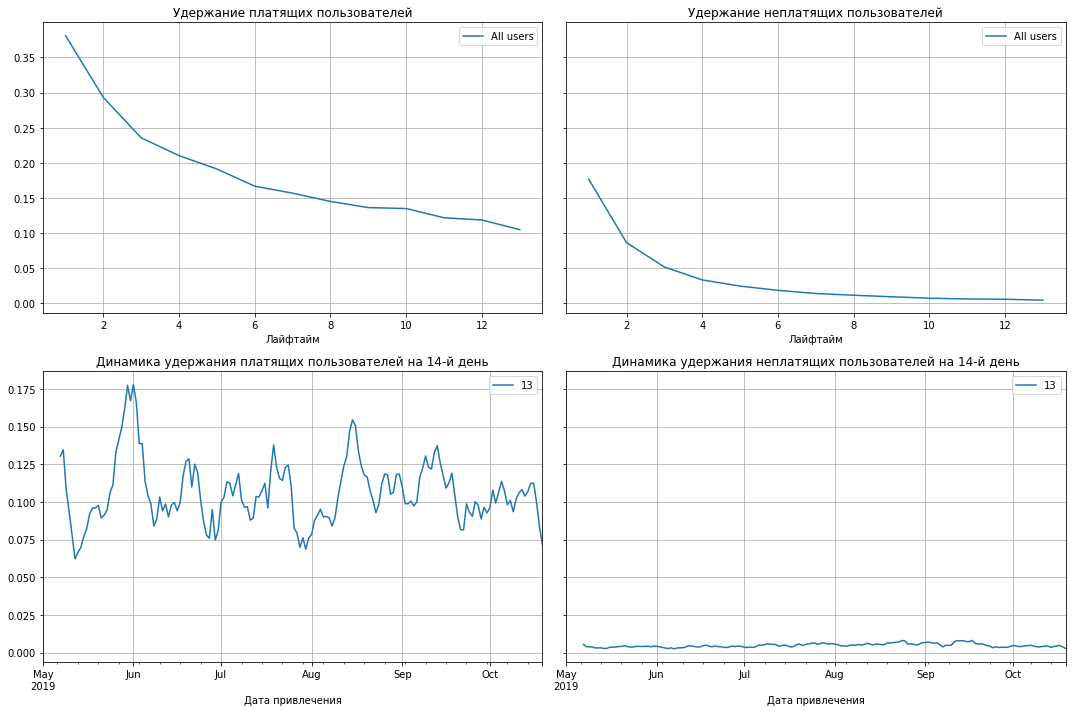

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание на протяжении исследуемого периода падает как у платящих, так и неплатящих пользователей. Количество активных пользователей в первый день было выше, чем в последующие. В начале периода показатель больше 35%, концу периода - чуть больше 10%.

Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

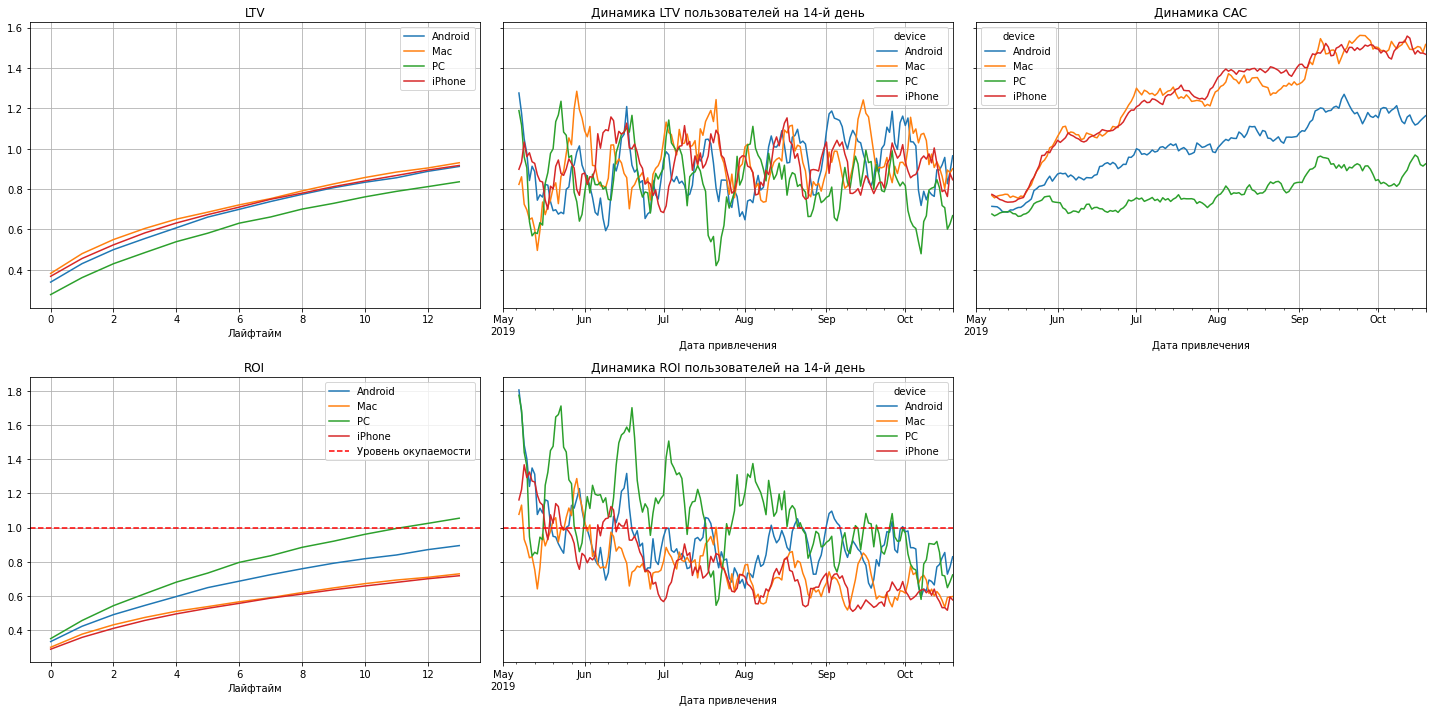

In [42]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
) 

Согласно графикам в разрезе платформы, видно следующее:  
    - Показатели платформ iPhone, Mac и Android практически идентичны, пользователи PC приносят меньше денег компании;  
    - Что касается CAC, лидируют показатели у платформ iPhone и Mac. На платформе PC клиент стоит дешевле всего;  
    - Несмотря на плохие, казалось бы на первый взгляд, показатели LTV у платформы PC, она единственная окупается, в то время как Mac, iPhone и Android не окупились.


**Графики окупаемости рекламы с разбивкой по странам:**

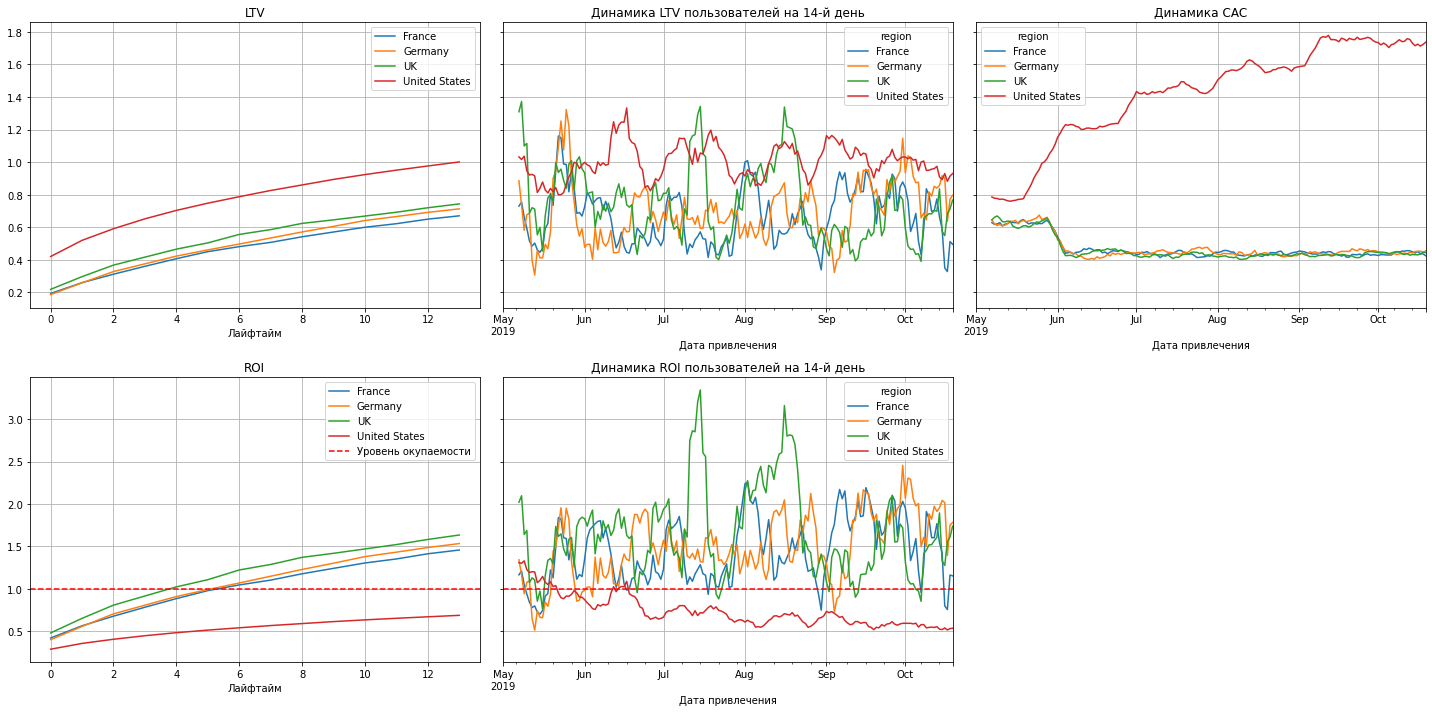

In [43]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
) 

Глядя на графики в разрезе страны, можно сказать следующие виды:  
    - Лидером среди стран по доходу от пользователя является США, остальные три страны - Германия, Франция и Британия приносят меньше дохода.  
    - Что касается CAC, США значительно лидирует, остальные страны примерно равны  по расходам на привлечение одного клиента;  
    - Окупаются волжения во все страны, кроме США. Окупаются достаточно быстро и примерно в одно время.

**Графики окупаемости рекламы с разбивкой по рекламным каналам:**

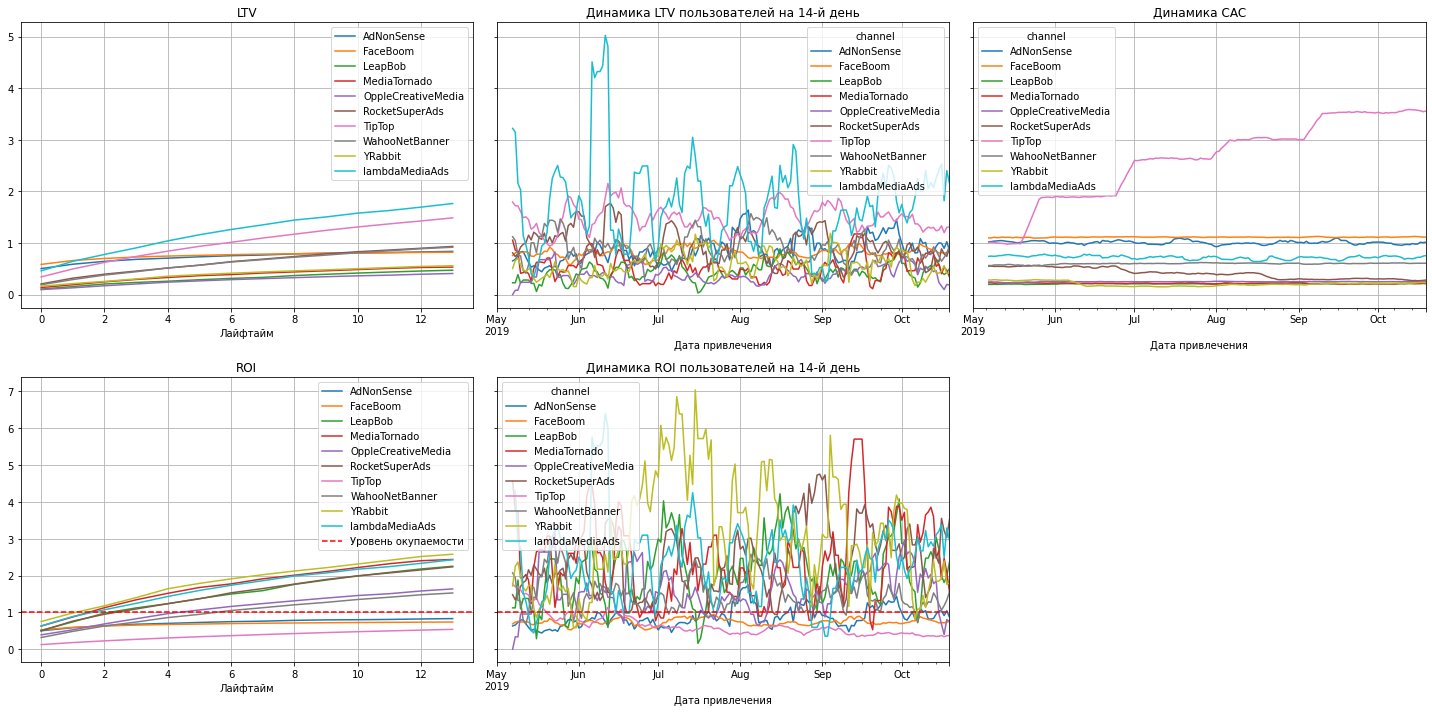

In [44]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
) 

Согласно графикам в разрезе канала, видно следующее:  
    - Выше всего LTV у AdNonSense, на втором месте TipTop;  
    - У канала TipTop значитеьно растёт стоимость привлечения одного клиента, как и было выявлено ранее.Это может быть связано с рекламой у блогеров, которая достаточно быстро вымывается. На остальные каналы расходы приходились равномерно;  
    - Быстрее всего окупился YRabbit. Не окупились TipTop, FaceBoom и AdNonSense.

В целом реклама не окупается, что говорит о неэффективном распределении денежных средств на продвижение приложения.  
Несмотря на то, что пользователи приносят больше всего денег в США, с канала TipTop или на платформе iPhone, реклама совершенно не окупается, так как денег вливают намного больше.  
Стоит пересмотреть рекламные объявления, преподносимые клиентам. Возможно для некоторых платформ,стран или каналов она отображается не совсем корректно (неудачный шрифт, баннер или разрешение). Если повторно рассмотреть свои кампании, перераспределить средства, снизив убыточные направления, окупаемость вырастет и настанет раньше.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

# Вывод

Для вывления возможнвх причин убытков компании было проведено исследование на основе предоставленных статистических данных. Исследование состояло из нескольких этапов:  
1. Обзор и предобработка данных;
2. Анализ данных;
3. Вывод и рекомендации по произведённому анализу.


**Первый этап**  
Для более корректного и наглядного отображения данных:  
* были проверены пустые значения и дубликаты;
* скорректированы названия столбцов;
* скорректированы типы данных в столбцах с датой.  



**Второй этап**  
В ходе анализа предоставленных данных были выявлены следующие моменты:  

1. Подавляющее большинство пользователей зарегистрированы в США (более 100тыс или 60% общего количества). Также в США самый высокий процент покупателей среди пользователей. В тройку лидеров также входят Британия (11,7%) и Франция (11,6%) с практически равным количеством пользователей, на втором месте по покупкам находится Германия.
 
2. Большинство пользователей используют IPhone (36,3%), на втором месте Android (23,4%). На третьем месте по популярности пользователи используют PC, однако покупки с них совершают меньше всего по отношению к количеству пользователей. Лидируют по покупкам пользователи, использующие Mac и IPhone - чуть больше 6%.

3. Больше всего пользователей приходят не через рекламу (37,6%), однако по покупательской способности органика на последнем месте (2%). Наибольшее кол-во покупок совершают пользователи, которые пришли из канала FaceBoom (12,2). На втором и третьем местах находятся каналы с наименьшим количеством пользователей: AdNonSense и lambdaMediaAds. Стоит обратить внимание на наиболее конвертирующие каналы. 

4. На TipTop и FaceBoom приходится наибольшее количество затрат, причём с большим отрывом от остальных: затраты на WahooNetBanner в 6 раз меньше, чем у FaceBoom.  

5. Глядя на общий хитмеп конверсии, видно, что Converstion Rate перманентно увеличивается на протяжении всего исследуемого периода. Количество покупателей в приложении Procrastinate Pro+ увеличивается с каждым днём, с 5,88% до 8,02%.

6. Удержание на протяжении исследуемого периода падает как у платящих, так и неплатящих пользователей. Количество активных пользователей в первый день было выше, чем в последующие. В начале периода показатель больше 35%, концу периода - чуть больше 10%.

7. Наиболее высокие показатели демонстрирует платформа Mac, чуть хуже конвертят пользователи, использующие платформы iPhone и Android. Хуже всех конверсия наблюдается у пользователей на платформе PC. На графике динамики видно, что показатели конверсии нестабильны, также принимают самые минимальные значения.

8. На графике удержания платящих пользователей очевидно лидируют пользователи PC. На протяжении всех лайфтаймов этот вид устройства лидирует, однако на шестой день показатель практически равняется с пользователями Android. График удержания неплатящих пользователей примерно равен для всех платформ.

9. Расходы на рекламу также возрастают, однако согласно ROI только под конец исследуемого периода реклама почти окупается. Согласно динамике ROI, она стремительно падает.  

10. Согласно графикам в разрезе платформы, видно следующее:  
- Показатели платформ iPhone, Mac и Android практически идентичны, пользовтели PC приносят меньше денег компании;  
- Что касается CAC, лидируют показатели у платформ iPhone и Mac. На платформу PC приходится самое дешёвое привлечение одного клиента;  
- Несмотря на плохие, казалось бы на первый взгляд, показатели LTV у платформы PC, она единственная окупается, в то время как Mac, iPhone и Android не окупились.  

11. Глядя на графики в разрезе страны, можно сказать следующие виды:  
- Лидером среди стран по доходу от пользователя является США, остальные три страны - Германия, Франция и Британия приносят меньше дохода;  
- Что касается CAC, США значительно лидирует, остальные страны примерно равны по расходам на привлечение одного клиента;  
- Окупаются волжения во все страны, кроме США. Окупаются достаточно быстро и примерно в одно время.  

12. Согласно графикам в разрезе канала, видно следующее:  
- Выше всего LTV у AdNonSense, на втором месте TipTop;  
- У канала TipTop значитеьно растёт стоимость привлечения одного клиента, как и было выявлено ранее.Это может быть связано с рекламой у блогеров, которая достаточно быстро вымывается. На остальные каналы расходы приходились равномерно;  
- Быстрее всего окупился YRabbit. Не окупились TipTop, FaceBoom и AdNonSense.  





**Третий этап**  

Учитывая проделанный анализ, можно отметить следующие рекомендации для отдела маркетинга:  


1. Необходимо провести проверку касательно рекламы в старанах помимо США. Возможно некорректно определена ЦА, от этого и реклама не конвертирует. Необходимо учитывать менталитет и традиции каждой страны, что хорошо отрабатывает в США, вполне веротно не будет также хорошо работать в Европе.  

2. Необходимо снизить расход рекламного бюджета с канала TipTop и перераспределить на другие каналы, которые окупаются в принципе. Влоэение в рекламу у блогеров не приносит должной прибыли.  

3. Следует обратить внимание на канал AdNonSense, поскольку он окупился, и к тому же процент платящих пользователей высок в сравнении с большинством остальных.  

4. Также можно рассмотреть для приоритезации канал Yrabbit: несмотря на низкий LTV, у данного канала также низкий CAC, поэтому он и окупился быстрее всех.

